In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

### Section on story telling?

## 1. Data wrangling and EDA

#### 1.1 Feature selection

In [2]:
df = pd.read_csv('data_atlas/atlas.csv') # County data for all features
allfeatures = pd.read_csv('data_atlas/variables.csv',index_col='Category Code') # Feature names and details

# Filter out features not to be considered
# 1)Remove variables that measure '% change' between years, labeled as 'classification' and 'Legend'
feature_filter1 = allfeatures.loc[(allfeatures['Units']!='% change')
                                  &(allfeatures['Units']!='Classification')
                                  &(allfeatures['Units']!='Legend')]


# 2) For features that have two or more years, choose the most recent one only
# Split variable name in order to sort by years
feature_filter2 = pd.DataFrame(feature_filter1['Variable Name'].str.rsplit(', ',1).tolist(), columns=['Variable','Year']) 
feature = pd.concat([feature_filter1.reset_index(),feature_filter2],axis=1)

# # Sort by year and only keep the most recent year
feature = feature.sort_values(by='Year', ascending=False)
feature = feature.drop_duplicates(subset='Variable',keep='first')
feature = feature.set_index('Category Code')

# # Slice dataframe with the selected features plus county info
df = df.loc[:,['FIPS','State','County'] + feature['Variable Code'].tolist()] # Select data with updated features

In [3]:
# Yielded 138 features
print(feature.shape) 
print(df.shape)

(138, 9)
(3143, 141)


In [4]:
# Calculate state average values for each feature
states = (df.drop(['FIPS','County'], axis=1)).groupby('State').mean()
states.head()

,PCT_SNAP16,FOODHUB16,PCT_FMRKT_BAKED16,PCT_FMRKT_WICCASH16,FMRKT_ANMLPROD16,FMRKT_BAKED16,FMRKT_OTHERFOOD16,PCT_FMRKT_OTHERFOOD16,SNAPS16,FMRKT_CREDIT16,...,PCT_NHBLACK10,PCT_NHWHITE10,PCH_SBP_09_15,PCH_CACFP_09_15,PCH_WIC_09_15,PCH_SFSP_09_15,PCH_NSLP_09_15,FOODINSEC_CHILD_03_11,CH_FOODINSEC_12_15,CH_VLFOODSEC_12_15
State,,,,,,,,,,,,,,,,,,,,,
AK,11.555155,0.034483,44.722222,14.930556,1.250000,1.666667,1.583333,43.333333,17.812500,1.500000,...,1.131494,50.622066,0.974895,0.047075,-1.030685,0.456487,-0.406381,8.0,1.2,0.0
AL,16.976436,0.014925,40.419840,4.817708,0.765625,0.937500,1.046875,47.581298,72.636816,0.750000,...,28.250668,66.101869,0.723991,0.139507,-0.271065,0.462219,-1.380526,9.3,-0.3,0.5
AR,13.647462,0.013333,47.870813,7.030835,1.000000,1.000000,1.017544,48.221691,34.865556,0.824561,...,15.771596,76.993259,0.687514,0.760854,-0.429053,0.438172,-1.402372,11.5,0.0,-0.4
AZ,13.527693,0.200000,57.625466,35.696362,4.615385,4.461538,4.692308,50.985098,254.811111,5.615385,...,1.646774,52.825171,1.008930,-0.070693,-0.719922,0.046385,-0.456826,10.9,-0.5,-0.7
CA,10.961725,0.206897,52.136262,13.864407,6.392857,7.321429,7.125000,52.348241,412.377193,7.017857,...,3.041599,57.095504,1.148466,0.551509,-0.661636,0.069882,-0.231813,10.8,-3.0,-1.2


In [5]:
# Check for outliners

# For loop to find outliers and convert them to NaN
outliers = {}
for column in states:
    data = states[column]
    mean = data.mean()
    std = data.std()
    # Define outliers and find their indexes
    outlier = data[(data > (mean+3*std))|(data < (mean-3*std))] # Alternatively: low,high = np.percentile(data,[1,99])
    slice_index = outlier.index # 
    # If there is no outlier in this column, go back to the beginning of the loop
    if slice_index.shape[0] == 0: continue   
    # Append outliers in a dictionary
    outliers[column]=states[column].loc[slice_index]
    # Convert outliers into NaN and remove from regression analysis later
    
    data[(data > (mean+3*std))|(data < (mean-3*std))] = np.NaN

len(outliers)

92

In [6]:
# check for missing values (outliers included as NaN)
states.isna().sum().sum()

153

In [7]:
#### Regress each variable with the health variable 'PCT_DIABETES_ADULTS13' and put significant variables in a dictionary sig_var
# Outliers and missing values at state level are removed from regression analysis. 

from scipy.stats import linregress

sig_var = {}
sig_r = {}

for column in states.drop('PCT_DIABETES_ADULTS13', axis=1):
    
    mask = ~np.isnan(states[column]) & ~np.isnan(states['PCT_DIABETES_ADULTS13']) # Mask Nan from regressions
    # Linear regression
    slope, intercept,rvalue, pvalue, stderr = linregress(states[column][mask], states['PCT_DIABETES_ADULTS13'][mask])
    
    # Return to the top of loop if not significant
    if pvalue >= 0.05: continue
    
    # Append significant variables to the dictionary      
    sig_var[column] = [slope, intercept, rvalue, pvalue, stderr]
    sig_r[column] = rvalue

In [8]:
# Sort dictionary
sorted_sig_r_tuples = sorted(sig_r.items(), key=lambda x:x[1]) # Output tuples

# If plot directly without using features' full names
import collections
sorted_sig_r = collections.OrderedDict(sorted_sig_r_tuples) # Convert to dict

In [9]:
len(sorted_sig_r_tuples)

67

In [10]:
# Read in the variables list 
variables=pd.read_csv('data_atlas/variables.csv')
#Change column names
variables.columns=['Category','CategoryCode','SubName','VarName','VarCode','Selected','Geography','Unites']

# Update the detailed selected feature names in a new dict
varname = variables.loc[variables['VarCode'].isin(sorted_sig_r.keys()),['VarCode','VarName']]

# Combine detailed feature names
features = pd.DataFrame(sorted_sig_r_tuples)
features.columns = ['VarCode','r']
features = pd.merge(features,varname, on = 'VarCode') # Combine full feature names
features = features.set_index('VarName')

In [11]:
len(features)
features.to_csv('data_atlas/64features_010820.csv')

In [12]:
# 28 features are selected for regression analysis
shortlist=['Full-service restaurants/1,000 pop, 2014',
 'Median household income, 2015',
 'Direct farm sales per capita, 2012',
 'Agritourism receipts, 2012',
 'Grocery stores/1,000 pop, 2014',         
 'Specialized food stores/1,000 pop, 2014',
 'Recreation & fitness facilities/1,000 pop, 2014',
 'Price of sodas/national average, 2010**',
 'Farms with direct sales (%), 2012',
 'Greenhouse vegetable and fresh herb farms, 2012',
 'Expenditures per capita, restaurants, 2012*',
 "Farmers' markets/1,000 pop, 2016",
 'CSA farms, 2012',
 'Population, low access to store (%), 2015',
 'Vegetable farms, 2012',
 'Farms with vegetables harvested for fresh market, 2012',

 'Price of low-fat milk/price of sodas, 2010**',
 'Convenience stores/1,000 pop, 2014',
 'Expenditures per capita, fast food, 2012*',
 'Household food insecurity (%, three-year average), 2013-15*',
 'National School Lunch Program participants (% pop), 2015*',
 'SNAP participants (% pop), 2016*',
 'Students eligible for free lunch (%), 2014',
 'Supercenters & club stores/1,000 pop, 2014',
 'School Breakfast Program participants (% pop), 2015*',
 'SNAP-authorized stores/1,000 pop, 2016',
 'Poverty rate, 2015',
 'Households, no car & low access to store (%), 2015',
 ]
# year range from 2010 to 2016

# Remove year label for simplifying plotting
Feature_names = ['Full-service restaurants/1,000 pop',
 'Median household income',
 'Direct farm sales per capita',
 'Agritourism receipts',
 'Grocery stores/1,000 pop',         
 'Specialized food stores/1,000 pop',
 'Recreation & fitness facilities/1,000 pop',
 'Price of sodas/national average',
 'Farms with direct sales (%)',
 'Greenhouse vegetable and fresh herb farms',
 'Expenditures per capita, restaurants',
 "Farmers' markets/1,000 pop",
 'CSA farms',
 'Population, low access to store (%)',
 'Vegetable farms',
 'Farms with vegetables harvested for fresh market',
 'Price of low-fat milk/price of sodas',
 'Convenience stores/1,000 pop',
 'Expenditures per capita, fast food',
 'Household food insecurity (%, three-year average)',
 'National School Lunch Program participants (% pop)',
 'SNAP participants (% pop)',
 'Students eligible for free lunch (%)',
 'Supercenters & club stores/1,000 pop',
 'School Breakfast Program participants (% pop)',
 'SNAP-authorized stores/1,000 pop',
 'Poverty rate, 2015',
 'Households, no car & low access to store (%)',
 ]

shortlist = pd.DataFrame({'VarName':shortlist,'ShortName':Feature_names})
shortlist = shortlist.set_index('VarName')

In [13]:
shortfeatures = features.join(shortlist,how='inner')

In [14]:
# Subset features dataframe 
shortfeatures.head()

,VarCode,r,ShortName
VarName,,,
"Full-service restaurants/1,000 pop, 2014",FSRPTH14,-0.699661,"Full-service restaurants/1,000 pop"
"Median household income, 2015",MEDHHINC15,-0.683195,Median household income
"Direct farm sales per capita, 2012",PC_DIRSALES12,-0.566868,Direct farm sales per capita
"Agritourism receipts, 2012",AGRITRSM_RCT12,-0.532238,Agritourism receipts
"Grocery stores/1,000 pop, 2014",GROCPTH14,-0.519540,"Grocery stores/1,000 pop"


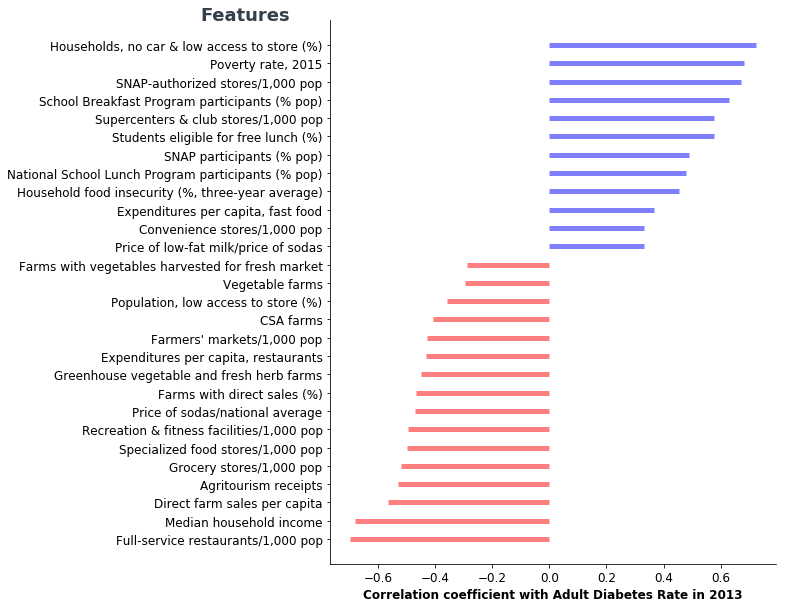

In [15]:
# Visualize significant features
# Reference: https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html

# A numeric placeholder for the y axis
my_range=list(range(1,len(shortfeatures.index)+1))

fig, ax = plt.subplots(figsize=(8,10))

colors = ['red']*16+['blue']*12 # create color lists for negative and positive correlated features

plt.hlines(y=my_range, xmin=0, xmax=shortfeatures['r'], color=colors, alpha=0.5, linewidth=5)

# set labels
ax.set_xlabel('Correlation coefficient with Adult Diabetes Rate in 2013', fontsize=12,fontweight='black')
#ax.set_ylabel('Features')

# # set axis
ax.tick_params(axis='both',which='major',labelsize=12)
#plt.yticks(my_range,shortfeatures['VarName'],fontsize=12)
plt.yticks(my_range,Feature_names,fontsize=12)

# # add an horizonal label for the y axis 
fig.text(-0.1, 0.88, 'Features', fontsize=18, fontweight='black', color = '#333F4B')

# Remove right and top borders
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

plt.savefig('shortlist_features.png', dpi=600,bbox_inches='tight')

#### 1.2 Dealing with missing values and outliers for County-level data


In [16]:
# Fill missing values using Iterative imputer
# which is a mmultivariate imputer that estimates each feature from all others
# Default estimator is BayesianRidge 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp_mean = IterativeImputer(min_value=0,random_state=0) # All values should be non negative


In [17]:
transformed = imp_mean.fit_transform(df.drop(['FIPS','State','County'],axis=1))

/Users/Sabrina/anaconda3/lib/python3.6/site-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [18]:
df_imp = pd.DataFrame(transformed)
df_imp.columns = df.drop(['FIPS','State','County'],axis=1).columns
df_imp = pd.concat([df.loc[:,['FIPS','State','County']],df_imp],axis=1)

In [19]:
# Check examples of imputed missing values for DC
df_imp.loc[df_imp['State']=='DC',['FRESHVEG_ACRES12','GHVEG_FARMS12']]
# It sounds reasonable that DC has 0 fresh vegetable acres for fresh market 
# and around 10 greenhouse vegetable farms, since it is a metro aera.

,FRESHVEG_ACRES12,GHVEG_FARMS12
319,0.0,10.404155


In [20]:
df_imp.shape

(3143, 141)

In [21]:
# Winsorization of outliers 
from scipy.stats.mstats import winsorize

df_winsorized = df_imp.copy()
for column in df_winsorized.iloc[:,3:]:
    df_winsorized[column]=winsorize(df_winsorized[column],limits=[0.05,0.05])


### Need some EDA plots

# 2. Statistical analysis
### Mean comparisons using Student's t-test

**Null hypothesis 1**: Metro and non-metro counties have same means for adult diabetes rate in 2013  
**Null hypothesis 2**: Poverty and non-poverty counties have same means for adult diabetes rate in 2013

In [28]:
socio = pd.read_excel("atlas.xlsx", sheet_name= "SOCIOECONOMIC")
socio = socio.set_index('FIPS')
metro_info = pd.DataFrame(socio['METRO13'])
metro_info = metro_info.reset_index()

# Add metro info to dataframe
# Note here we use the original data rather than winsorized data, since the extreme diabetes rates in some counties are unlikely random mistakes
df2 = pd.concat([df,metro_info['METRO13']],axis=1) 

In [23]:
# Slice dataframe into Metro and non-metro counties 
metro = df2.loc[df2['METRO13']== 1,:]
nonmetro = df2.loc[df2['METRO13']== 0,:]
print('There are {} metro and {} non-metro counties.'.format(metro.shape[0],nonmetro.shape[0]))

There are 1167 metro and 1976 non-metro counties.


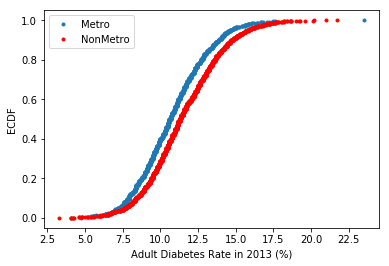

<Figure size 432x288 with 0 Axes>

In [24]:
# Visualization
# Plot the Empirical cumulative distribution of diabetes rates for metro and nonmetro counties

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements"""
    n =len(data)
    x = np.sort(data)
    y = np.arange(1,n+1)/n
    return x,y

x_metro, y_metro = ecdf(metro['PCT_DIABETES_ADULTS13'])
x_nonmetro, y_nonmetro = ecdf(nonmetro['PCT_DIABETES_ADULTS13'])

plt.plot(x_metro,y_metro,marker='.',linestyle='none',label='Metro')
plt.plot(x_nonmetro,y_nonmetro,marker='.',linestyle='none', color = 'red',label='NonMetro')
plt.xlabel('Adult Diabetes Rate in 2013 (%)')
plt.ylabel('ECDF')
plt.legend()
plt.show()

plt.savefig('Figs/metro_nonmetro_ecdf.png')

In [25]:
# t-test, assuming equal variances of the two groups
t1,p1 = stats.ttest_ind(metro['PCT_DIABETES_ADULTS13'],nonmetro['PCT_DIABETES_ADULTS13'],
                        nan_policy='omit')
print('p value:',round(p1,2))

p value: 0.0


#### Because p=0, we can reject null hypothesis 1 and conclude that there is significant differences in diabetes rate between metro and non-metro counties. Non-metro counties has higher diabetes rate. 
#### Next, let's examine persistant-poverty counties vs. non-poverty counties

In [29]:
# Add poverty county info to dataframe
df2 = pd.concat([df2,socio['PERPOV10'].reset_index()],axis=1)

# slice dataframe into poverty-persistaant counties and non-poverty counties
ppov = df2.loc[df2['PERPOV10']== 1,:]
nonppov = df2.loc[df2['PERPOV10']== 0,:]
print('There are {} ppov and {} non-ppov counties.'.format(ppov.shape[0],nonppov.shape[0]))

There are 353 ppov and 2790 non-ppov counties.


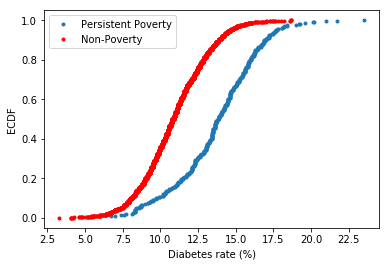

<Figure size 432x288 with 0 Axes>

In [30]:
x_ppov, y_ppov = ecdf(ppov['PCT_DIABETES_ADULTS13'])
x_nonppov, y_nonppov = ecdf(nonppov['PCT_DIABETES_ADULTS13'])

plt.plot(x_ppov, y_ppov,marker='.',linestyle='none',label='Persistent Poverty')
plt.plot(x_nonppov, y_nonppov,marker='.',linestyle='none', color = 'red',label='Non-Poverty')
plt.xlabel('Diabetes rate (%)')
plt.ylabel('ECDF')
plt.legend()
plt.show()

plt.savefig('Figs/ppov_nonppov_ecdf.png')

In [31]:
# Because the size of two groups are very different and likely have different variance, 
# we will perform Weltch's t-test by setting equal_var=False

t2,p2 = stats.ttest_ind(ppov['PCT_DIABETES_ADULTS13'],nonppov['PCT_DIABETES_ADULTS13'].dropna(),equal_var=False)
print('p value:',round(p2,2))

p value: 0.0


#### Because p=0, we can reject our hypothesis and conclude that the diabetes rate in non-poverty counties is significantly different (smaller than) persistent poverty counties.

In [32]:
pd.crosstab(df2['PERPOV10'],df2['METRO13'])

METRO13,0,1
PERPOV10,,
0,1675,1115
1,301,52


In [154]:
# Visualize average diabetes rates across the groups

# # Find county index 
# idx1 = metro.index.intersection(ppov.index)
# idx2 = metro.index.intersection(nonppov.index)
# idx3 = nonmetro.index.intersection(ppov.index)
# idx4 = nonmetro.index.intersection(nonppov.index)

# # Get mean values 
# metro_ppov = df2.loc[idx1,['PCT_DIABETES_ADULTS13']].mean()[0]
# metro_nonppov = df2.loc[idx2,['PCT_DIABETES_ADULTS13']].mean()[0]
# nonmetro_ppov = df2.loc[idx3,['PCT_DIABETES_ADULTS13']].mean()[0]
# nonmetro_nonppov = df2.loc[idx4,['PCT_DIABETES_ADULTS13']].mean()[0]

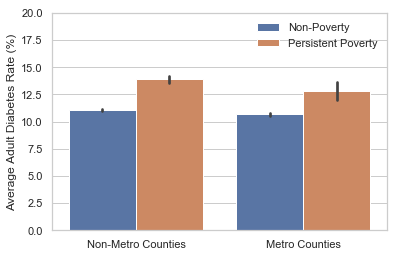

In [33]:
# Visualize average diabetes rates across the groups
sns.set(style="whitegrid")
ax = sns.barplot(x='METRO13',y='PCT_DIABETES_ADULTS13',hue='PERPOV10',data=df2) # showing standard error bars
ax.set_xticklabels(['Non-Metro Counties','Metro Counties'])
labels = ['Non-Poverty','Persistent Poverty']
h, l = ax.get_legend_handles_labels()
ax.legend(h,labels,frameon=False)

_ = plt.ylim(0,20)
_ = plt.ylabel('Average Adult Diabetes Rate (%)')
_ = plt.xlabel('')


plt.savefig('Figs/Avg_diabetes.png',dpi=600)


# 3. Predicting Diabetes--Supervised learning models
## 3.1 Linear regression

In [35]:
from sklearn.model_selection import train_test_split
# Slice cleaned dataframe with only 28 features
df_short = df_winsorized.loc[:, shortfeatures['VarCode'].tolist()]
df_short.shape

df_short2 = df_short.drop(['MEDHHINC15','FRESHVEG_FARMS12','VEG_FARMS12','PCT_NSLP15',
                     'PCT_FREE_LUNCH14','PCT_LACCESS_HHNV15',
                    'PCT_LOCLFARM12','GHVEG_FARMS12','PCT_SBP15','SNAPSPTH16',
                    'AGRITRSM_RCT12','PC_FFRSALES12','PC_DIRSALES12'],axis=1)

X = df_short2 # predictive features 
y = df_winsorized.PCT_DIABETES_ADULTS13 # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)

In [36]:
# Check if any two features are highly correlated
corr =df_short.corr() # Correlation matrix


corr2 =df_short.drop(['MEDHHINC15','FRESHVEG_FARMS12','VEG_FARMS12','PCT_NSLP15',
                     'PCT_FREE_LUNCH14','PCT_LACCESS_HHNV15',
                    'PCT_LOCLFARM12','GHVEG_FARMS12','PCT_SBP15','SNAPSPTH16',
                    'AGRITRSM_RCT12','PC_FFRSALES12','PC_DIRSALES12'],axis=1).corr() # Correlation matrix


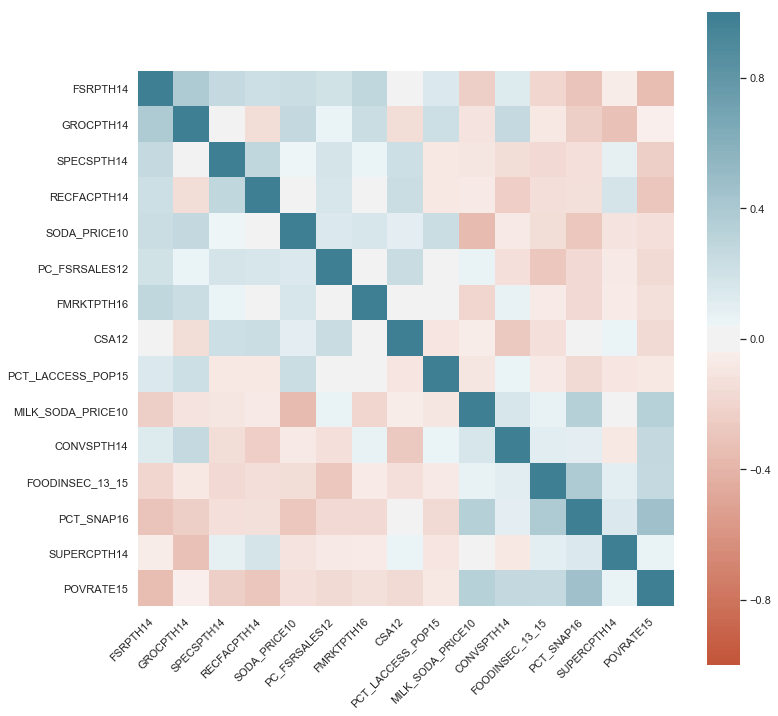

In [37]:
# Visualize correlation matrix with the reduced suite of features (15 total)
plt.figure(figsize=(12,12))
ax = sns.heatmap(
    corr2,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20,220,n=200),
    square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

#plt.show()
plt.savefig('Figs/correlation_matrix_15features.png',dpi=600)

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler=StandardScaler()
m1 = LinearRegression()
pipeline = make_pipeline(scaler,m1)

# Fit model with training data
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [39]:
scaled = scaler.fit_transform(X_train)

In [40]:
print('R-squared of training data:',pipeline.score(X_train,y_train))
print('R-squared of test data:',pipeline.score(X_test,y_test))

R-squared of training data: 0.513292245344822
R-squared of test data: 0.5598076477730355


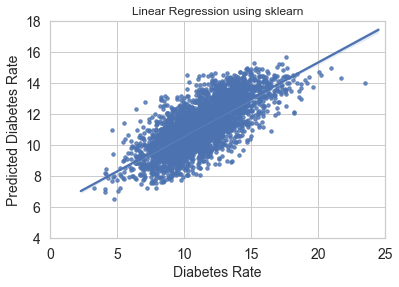

<Figure size 432x288 with 0 Axes>

In [41]:
##### Visualize fitted values by sklearn
# Plot with original diabeted data
sns.regplot(x=df.PCT_DIABETES_ADULTS13,y=pipeline.predict(X),scatter_kws={'s':12})
plt.xlabel('Diabetes Rate',fontsize=14)
plt.ylabel('Predicted Diabetes Rate',fontsize=14)
plt.xlim(0,25)
plt.ylim(4,18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Linear Regression using sklearn')
plt.show()
plt.savefig('Figs/MLR.png')

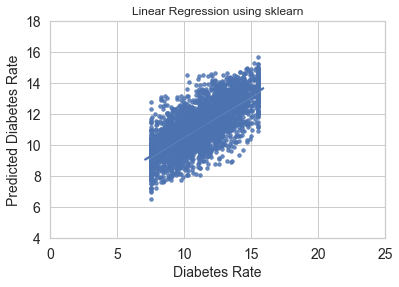

In [42]:
# Plot with winsorized diabetes data
sns.regplot(x=df_winsorized.PCT_DIABETES_ADULTS13,y=pipeline.predict(X),scatter_kws={'s':12})
plt.xlabel('Diabetes Rate',fontsize=14)
plt.ylabel('Predicted Diabetes Rate',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,25)
plt.ylim(4,18)
plt.title('Linear Regression using sklearn')
plt.show()

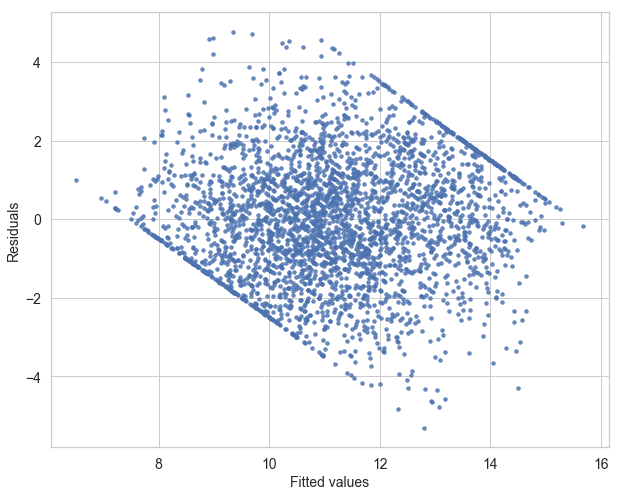

In [43]:
# Check model assumptions
# 1) Fitted value vs. residuals plot
plt.figure(figsize=(10,8))
resid = y - pipeline.predict(X)
_ = sns.regplot(x=pipeline.predict(X),y=resid,fit_reg=False,scatter_kws={'s':12})
_ = plt.xlabel('Fitted values',fontsize=14)
_ = plt.ylabel('Residuals',fontsize=14)
_ = plt.xticks(fontsize=14)
_ = plt.yticks(fontsize=14)
plt.savefig('Figs/homoscedasticity_m1.png',)

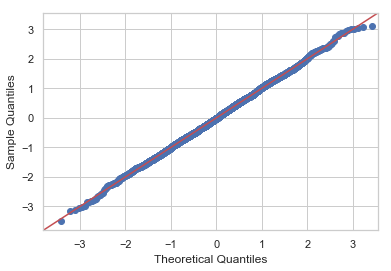

In [44]:
# 2): Quantile plot of the residuals
import statsmodels.api as sm
fig = sm.qqplot(resid, stats.t, fit=True, line='45')
plt.savefig('Figs/qqplot_m1.png')

In [45]:
# Get the coefficients
coefs = pd.DataFrame({'VarCode': X.columns, 'estimatedCoefficients': m1.coef_})[['VarCode', 'estimatedCoefficients']]
coefs = coefs.sort_values(by='estimatedCoefficients')
coefs.head()

,VarCode,estimatedCoefficients
5,PC_FSRSALES12,-0.350372
4,SODA_PRICE10,-0.307248
7,CSA12,-0.283506
3,RECFACPTH14,-0.219168
0,FSRPTH14,-0.215002


**Summary:** after checking for correlations among features and coeffients from initial regression, we removed 13 features and used 15 features for the final linear regression model. This resulted an R2= 0.51 for the training dataset and an R2= 0.56 for the testing dataset. Model assumptions on the homoscedasticity and normality of residuals were confirmed as well.  
The model may be underfitting, thus we shall look at more complex models such as Trees.

## 3.2 Decision Trees

In [46]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score

In [441]:
# tree = DecisionTreeRegressor(random_state=21)
# tree.fit(X_train,y_train)

# max_depth = [3,4,5]
# min_samples_split = list(range(10,51,10))
# min_samples_leaf = list(range(1,21,1))
# max_features = [3,4,5,6,7,8,9,10,11,12]

# parameters = {'max_depth':max_depth,
#              'min_samples_split':min_samples_split,
#              'min_samples_leaf':min_samples_leaf,
#              'max_features':max_features}

# m2 = GridSearchCV(tree,parameters)
# m2.fit(X_train,y_train)

/Users/Sabrina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=21,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 4],
                         'max_features': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
      

In [442]:
# Print best parameters
# print(m2.best_estimator_.get_params())

{'criterion': 'mse', 'max_depth': 4, 'max_features': 7, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 18, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 21, 'splitter': 'best'}


In [443]:
# Print cross-validation scores
# print(cross_val_score(m2, X_train,y_train))
# import warnings
# warnings.filterwarnings('ignore')

/Users/Sabrina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Sabrina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Sabrina/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0.45069354 0.47207096 0.41405235]


In [444]:
# print('Training data R-squared:',m2.score(X_train,y_train))
# print('Testing data R-squared:',m2.score(X_test,y_test))

Training data R-squared: 0.5467427994304069
Testing data R-squared: 0.49614648140337125


In [47]:
# Fit model using the best parameters in order to generate the tree plot

tree_best = DecisionTreeRegressor(max_depth= 4, max_features=7,min_samples_leaf= 18, min_samples_split= 10,
                                 random_state=21)
tree_best.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=7,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=18,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=21, splitter='best')

In [48]:
from sklearn.tree import export_graphviz

export_graphviz(tree_best, out_file='tree_gridsearch.dot',
               feature_names = X.columns)

In [49]:
from subprocess import call

call(['dot', '-T', 'png', 'Figs/tree_gridsearch.dot', '-o', 'Figs/tree_gridsearch.png'])

0

 <img src="Figs/tree_gridsearch.png">

**Summary:** After tuning hyperparameters and cross validation, our best decision tree obtained an R2= 0.55 for the training dataset and an R2= 0.50 for the testing dataset. The model is slightly overfitting.  
Thus we shall try Random Forest next to control for overfitting and improve model accuracy.
  
According to the this tree, the most important feature (root node) is **restaurant expenditures per capita** (PC_FSRSALES12). Features for the 2nd and 3rd splits include:
 - Price of low-fat milk/price of sodas (MILK_SODA_PRICE10)
 - Poverty rate (POVRATE15)
 - Specialized food stores/1,000 pop (SPECSPTH)
 - Food insecurity, three year average (FOODINSEC)
 - Recreation & fitness facilities/1,000 pop (RECFACPTH14)

## 3.3 Random Forest

In [50]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=21)

In [459]:
# Parameter tuning and gridsearch
# n_estimators = [60, 80, 100]
# max_depth = [4,5]
# min_samples_split = list(range(5,56,10))
# min_samples_leaf = [2,5,10]
# max_features = ['auto','sqrt']

# parameters = {'n_estimators':n_estimators,
#              'max_depth':max_depth,
#              'min_samples_split':min_samples_split,
#              'min_samples_leaf':min_samples_leaf,
#              'max_features':max_features}

# rf_grid = GridSearchCV(rf,parameters,cv=5)
# rf_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=21,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [4, 5], 'max_feature

In [460]:
# Print best parameters
print(rf_grid.best_estimator_.get_params())

{'bootstrap': True, 'criterion': 'mse', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 80, 'n_jobs': None, 'oob_score': False, 'random_state': 21, 'verbose': 0, 'warm_start': False}


In [462]:
# print('Training data R-squared:',round(rf_grid.score(X_train,y_train),2))
# print('Testing data R-squared:',round(rf_grid.score(X_test,y_test),2))

Training data R-squared: 0.68
Testing data R-squared: 0.63


In [51]:
# Build Randomforest regressor with best parameters
rf_best=RandomForestRegressor(max_depth= 5, 
min_samples_leaf= 2, 
min_samples_split= 5, 
n_estimators= 80)
rf_best.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=80,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [53]:
# Rank importance of features
importance =pd.DataFrame({'VarCode':X.columns, 'Importance':rf_best.feature_importances_}).sort_values(by=['Importance'],ascending=False)
importance = importance.set_index('VarCode')

# Worth trying permutation of feature importance?
#https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

In [54]:
importance = importance.join(shortfeatures.set_index('VarCode'))
importance.head()

,Importance,r,ShortName
VarCode,,,
PCT_SNAP16,0.319154,0.477796,SNAP participants (% pop)
POVRATE15,0.185901,0.683069,"Poverty rate, 2015"
PC_FSRSALES12,0.164366,-0.431063,"Expenditures per capita, restaurants"
FOODINSEC_13_15,0.064859,0.455828,"Household food insecurity (%, three-year average)"
CONVSPTH14,0.060134,0.331765,"Convenience stores/1,000 pop"


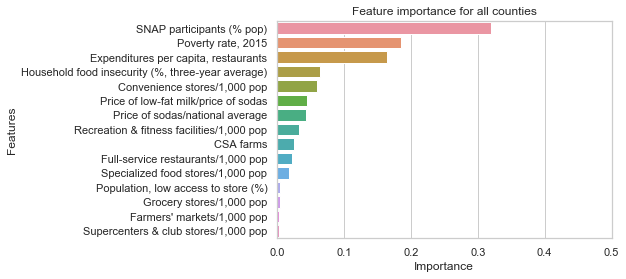

In [55]:
#plt.figure(figsize=(12,8))

sns.barplot(y='ShortName', x='Importance', data=importance)
plt.ylabel('Features')
plt.xlim(0,0.5)
plt.title('Feature importance for all counties')
plt.savefig('Figs/importance_rf_15features.png',bbox_inches='tight')

**Summary:** 
After tuning hyperparameters and cross validation, our best decision tree obtained an R2= 0.68 for the training dataset and an R2= 0.63 for the testing dataset. The model accuracy improved comparing to linear regression a single decision tree. It may be slightly overfitting.



### Random forest for Metro and Non-Metro counties, respectively

In [56]:
# Create metro and non-metro data frames for the shortlist features 
df3 = pd.concat([df_winsorized,metro_info['METRO13']],axis=1) 
# Slice dataframe into Metro and non-metro counties 
metro_winsorized = df3.loc[df3['METRO13']== 1,:]
nonmetro_winsorized = df3.loc[df3['METRO13']== 0,:]

X2 = pd.concat([df_short2,df['FIPS']],axis=1)
X2 = pd.concat([X2,metro_info['METRO13']], axis=1)

ymetro = df3.loc[df3['METRO13']== 1,'PCT_DIABETES_ADULTS13']
ynonmetro = df3.loc[df3['METRO13']== 0,'PCT_DIABETES_ADULTS13']

In [57]:
# Splite data into training and testing sets
Xmetro = X2.loc[X2['METRO13']==1,:]
Xnonmetro = X2.loc[X2['METRO13']==0,:]
Xmetro_train, Xmetro_test, ymetro_train, ymetro_test = train_test_split(Xmetro, ymetro, test_size=0.2, random_state=5)
Xnonmetro_train, Xnonmetro_test, ynonmetro_train, ynonmetro_test = train_test_split(Xnonmetro, ynonmetro, test_size=0.2, random_state=5)

In [878]:
# Parameter tuning and gridsearch for Metro counties
# n_estimators = [100, 120, 140]
# max_depth = [3,4]
# min_samples_split = list(range(5,26,5))
# min_samples_leaf = [2,5,10]
# max_features = ['auto','sqrt']

# parameters = {'n_estimators':n_estimators,
#              'max_depth':max_depth,
#              'min_samples_split':min_samples_split,
#              'min_samples_leaf':min_samples_leaf,
#              'max_features':max_features}

# rf_grid_metro = GridSearchCV(rf,parameters,cv=5)
# rf_grid_metro.fit(Xmetro_train,ymetro_train)

# rf_grid_nonmetro = GridSearchCV(rf,parameters,cv=5)
# rf_grid_nonmetro.fit(Xnonmetro_train,ynonmetro_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=21,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [3, 4], 'max_feature

In [879]:
# Print best parameters for Metro and non-Metro counties
# print(rf_grid_metro.best_estimator_.get_params())
# print('Metro: Training data R-squared:',round(rf_grid_metro.score(Xmetro_train,ymetro_train),2))
# print('Metro: Testing data R-squared:',round(rf_grid_metro.score(Xmetro_test,ymetro_test),2))

# print(rf_grid_nonmetro.best_estimator_.get_params())
# print('Non-Metro: Training data R-squared:',round(rf_grid_metro.score(Xnonmetro_train,ynonmetro_train),2))
# print('Non-Metro: Testing data R-squared:',round(rf_grid_metro.score(Xnonmetro_test,ynonmetro_test),2))


{'bootstrap': True, 'criterion': 'mse', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 120, 'n_jobs': None, 'oob_score': False, 'random_state': 21, 'verbose': 0, 'warm_start': False}
Metro: Training data R-squared: 0.65
Metro: Testing data R-squared: 0.6
{'bootstrap': True, 'criterion': 'mse', 'max_depth': 4, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 120, 'n_jobs': None, 'oob_score': False, 'random_state': 21, 'verbose': 0, 'warm_start': False}
Non-Metro: Training data R-squared: 0.53
Non-Metro: Testing data R-squared: 0.5


In [58]:
# Build Randomforest regressor with best parameters for Metro and Non-Metro counties
rf_metro_best=RandomForestRegressor(max_depth= 4, 
min_samples_leaf= 5, 
min_samples_split= 5, 
n_estimators= 120)
rf_metro_best.fit(Xmetro_train,ymetro_train)

rf_nonmetro_best=RandomForestRegressor(max_depth= 4, 
min_samples_leaf= 2, 
min_samples_split= 10, 
n_estimators= 120)
rf_nonmetro_best.fit(Xnonmetro_train,ynonmetro_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=120,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

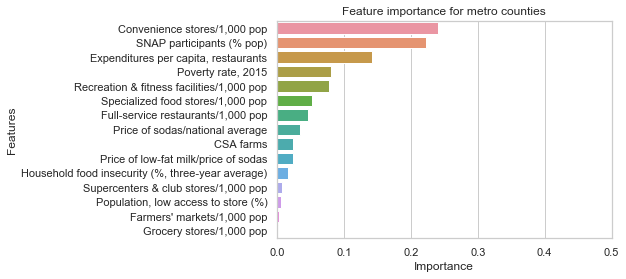

In [59]:
# Rank importance of features for Metro counties
importance_metro =pd.DataFrame({'VarCode':X2.columns, 'Importance':rf_metro_best.feature_importances_}).sort_values(by=['Importance'],ascending=False)
importance_metro = importance_metro.set_index('VarCode')
importance_metro
importance_metro = importance_metro.join(shortfeatures.set_index('VarCode'))
importance.head()

sns.barplot(y='ShortName', x='Importance', data=importance_metro)
plt.ylabel('Features')
plt.xlim(0,0.5)
plt.title('Feature importance for metro counties')
plt.savefig('Figs/importance_rf_15features_metro.png',bbox_inches='tight')


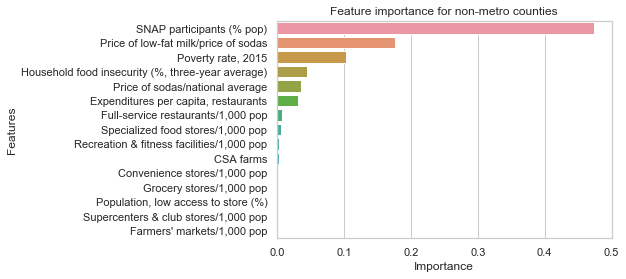

In [60]:
# Rank importance of features for Non-Metro counties
importance_nonmetro =pd.DataFrame({'VarCode':X2.columns, 'Importance':rf_nonmetro_best.feature_importances_}).sort_values(by=['Importance'],ascending=False)
importance_nonmetro = importance_nonmetro.set_index('VarCode')
importance_nonmetro
importance_nonmetro = importance_nonmetro.join(shortfeatures.set_index('VarCode'))
importance_nonmetro.head()

sns.barplot(y='ShortName', x='Importance', data=importance_nonmetro)
plt.ylabel('Features')
plt.xlim(0,0.5)
plt.title('Feature importance for non-metro counties')
plt.savefig('Figs/importance_rf_15features_nonmetro.png',bbox_inches='tight')

# 4. Finding patterns of food environment among counties (unsupervised learning)
## 4.1 PCA

In [61]:
# PCA analysis is applied on four groups of variables: local, restaurants, stores, and the 15 shortlist features 

# Select subcategories of focus: local (farms, farmer's market etc.), restaurants, stores
local = df_winsorized.loc[:,feature.loc['LOCAL','Variable Code'].tolist()]
restaurants = df_winsorized.loc[:,feature.loc['RESTAURANTS','Variable Code'].tolist()]
stores = df_winsorized.loc[:,feature.loc['STORES','Variable Code'].tolist()]

# 15 shortlist features used in supervised learning
features15 = df_winsorized.loc[:,importance.index]

print(local.shape,restaurants.shape,stores.shape)

(3143, 45) (3143, 6) (3143, 12)


In [62]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler=StandardScaler()
local_scaled = scaler.fit_transform(local)   # 'LOCAL' category
restaurants_scaled = scaler.fit_transform(restaurants)  # 'LOCAL' category
stores_scaled = scaler.fit_transform(stores)   # 'LOCAL' category


0.5119722288113535


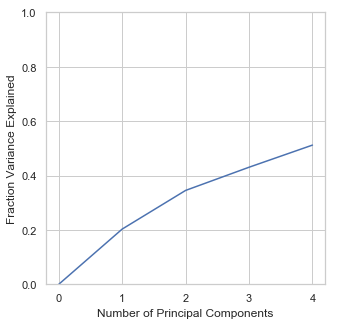

In [63]:
# 15 shortlist features
pca_shortlist15 = PCA(n_components=4)
pca_features_shortlist15 = pca_shortlist15.fit_transform(scaler.fit_transform(features15))
features = range(pca_shortlist15.n_components_)

tally=0
scree=[0]
for percent in pca_shortlist15.explained_variance_ratio_:
    tally+=percent
    scree.append(tally)

plt.figure(figsize=(5,5)) 
plt.plot(scree)   
plt.xlabel('Number of Principal Components')
plt.ylabel('Fraction Variance Explained')
plt.ylim(0,1)

print(scree[-1]) # First 4 components explained 51% variance

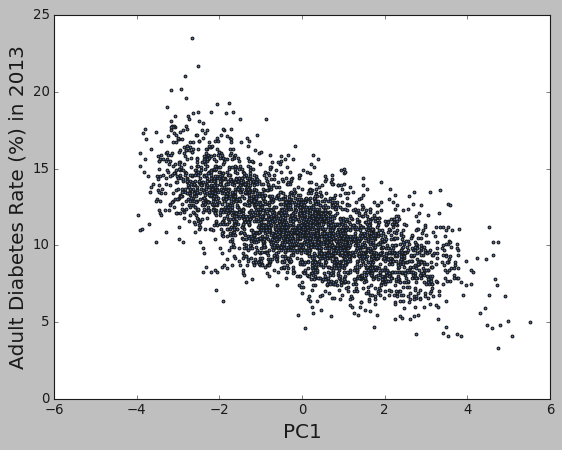

In [64]:
plt.style.use('classic')
plt.scatter(pca_features_shortlist15[:,0],df.PCT_DIABETES_ADULTS13,s=6)
plt.xlabel('PC1',fontsize=18)
plt.ylabel('Adult Diabetes Rate (%) in 2013',fontsize=18)
plt.savefig('Figs/PC1_diabetes.png')

0.5085295582665281


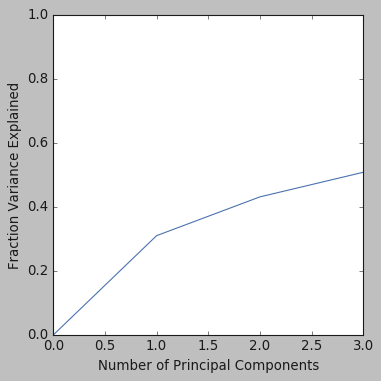

In [65]:
# 45 LOCAL variables 
pca_local = PCA(n_components=3)
pca_features_local = pca_local.fit_transform(local_scaled)
features = range(pca_local.n_components_)

tally=0
scree=[0]
for percent in pca_local.explained_variance_ratio_:
    tally+=percent
    scree.append(tally)

plt.figure(figsize=(5,5)) 
plt.plot(scree)   
plt.xlabel('Number of Principal Components')
plt.ylabel('Fraction Variance Explained')
plt.ylim(0,1)

print(scree[-1]) # First 3 components explained 51% variance

0.6102975946693096


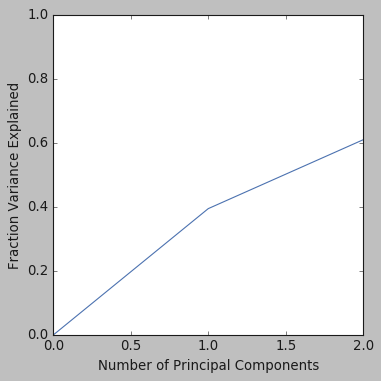

In [66]:
# 6 Restaurants variables
pca_restaurants = PCA(n_components=2)
pca_features_restaurants = pca_restaurants.fit_transform(restaurants_scaled)
features = range(pca_restaurants.n_components_)

tally=0
scree=[0]
for percent in pca_restaurants.explained_variance_ratio_:
    tally+=percent
    scree.append(tally)

plt.figure(figsize=(5,5)) 
plt.plot(scree)   
plt.xlabel('Number of Principal Components')
plt.ylabel('Fraction Variance Explained')
plt.ylim(0,1)

print(scree[-1]) # First 2 components explained 61% variance

0.6641885870340672


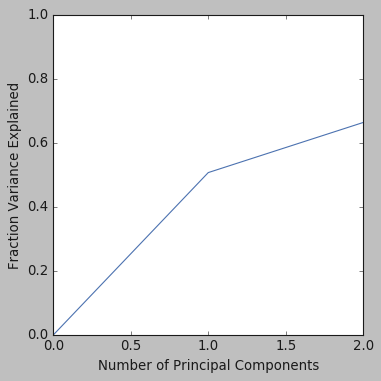

In [67]:
# 12 Stores variables
pca_stores = PCA(n_components=2)
pca_features_stores = pca_stores.fit_transform(stores_scaled)
features = range(pca_stores.n_components_)

tally=0
scree=[0]
for percent in pca_stores.explained_variance_ratio_:
    tally+=percent
    scree.append(tally)

plt.figure(figsize=(5,5)) 
plt.plot(scree)   
plt.xlabel('Number of Principal Components')
plt.ylabel('Fraction Variance Explained')
plt.ylim(0,1)

print(scree[-1]) # First 2 components explained 66% variance

## 4.1 K-means clustering

In [68]:
# Apply K means clustering to the first two PC components of each of the four groups analyzed above

from scipy import cluster
# https://docs.scipy.org/doc/scipy/reference/cluster.vq.html#module-scipy.cluster.vq

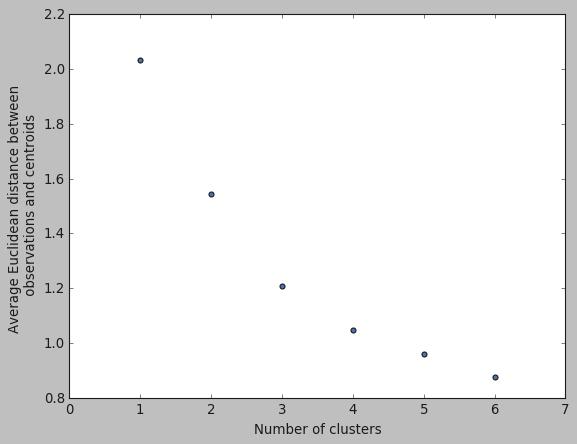

In [69]:
# Elbow plot, for 15 shortlist features
initial_shortlist = [cluster.vq.kmeans(pca_features_shortlist15[:,0:2],i) for i in range(1,7)]
plt.scatter(x=list(range(1,7)),y=[var for (cent,var) in initial_shortlist])
plt.xlabel('Number of clusters')
plt.ylabel('Average Euclidean distance between \n observations and centroids')
plt.show()

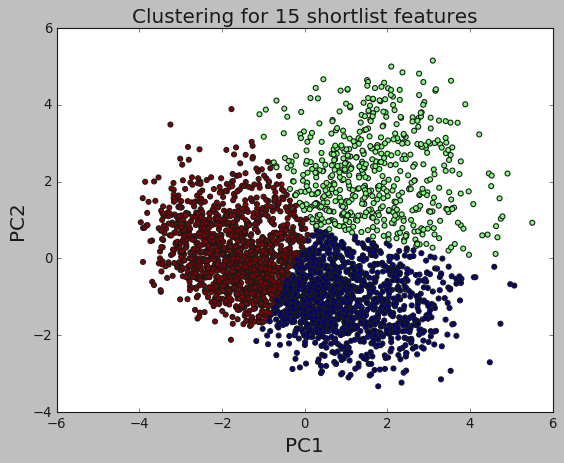

In [70]:
# Choose 3 clusters 
cent, var = initial_shortlist[2]
#use vq() to get as assignment for each obs.
assignment_shortlist,cdist = cluster.vq.vq(pca_features_shortlist15[:,0:2],cent)
plt.style.use('classic')
plt.scatter(pca_features_shortlist15[:,0], pca_features_shortlist15[:,1], c=assignment_shortlist)
plt.xlabel('PC1',fontsize=18)
plt.ylabel('PC2',fontsize=18)
plt.title('Clustering for 15 shortlist features',fontsize=18)
plt.savefig('Figs/cluster_15shortlist.png')
plt.show()

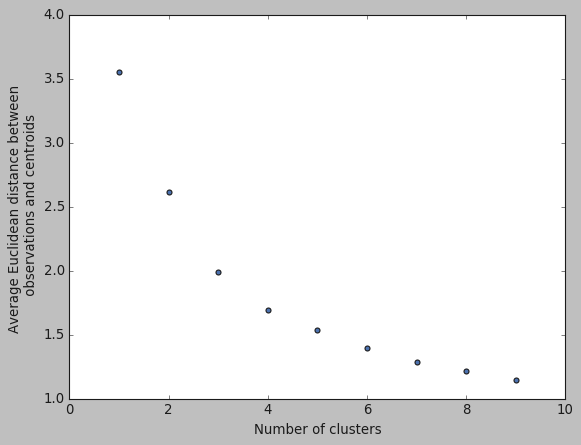

In [71]:
# Elbow plot, for 45 local variables
initial_local = [cluster.vq.kmeans(pca_features_local[:,0:2],i) for i in range(1,10)]
plt.scatter(x=list(range(1,10)),y=[var for (cent,var) in initial_local])
plt.xlabel('Number of clusters')
plt.ylabel('Average Euclidean distance between \n observations and centroids')

plt.show()

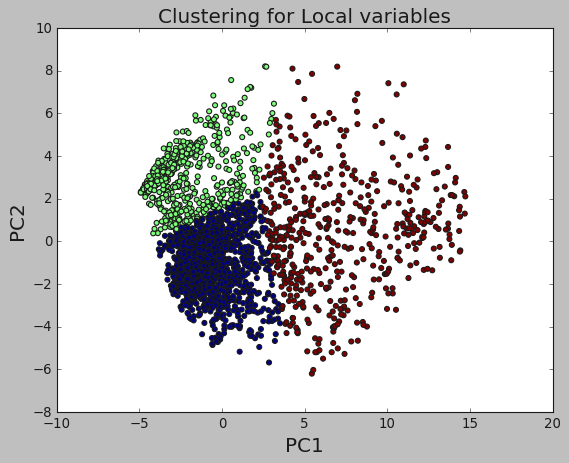

In [72]:
# Choose 3 clusters 
cent, var = initial_local[2]

assignment_local,cdist = cluster.vq.vq(pca_features_local[:,0:2],cent)

plt.style.use('classic')
plt.scatter(pca_features_local[:,0], pca_features_local[:,1], c=assignment_local)
plt.xlabel('PC1',fontsize=18)
plt.ylabel('PC2',fontsize=18)
plt.title('Clustering for Local variables',fontsize=18)
plt.savefig('Figs/cluster_local.png')
plt.show()

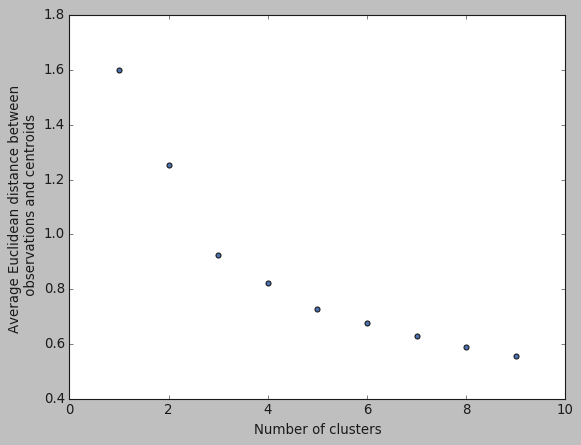

In [73]:
# Elbow plot, for 6 restaurant variables
initial_restaurants = [cluster.vq.kmeans(pca_features_restaurants[:,0:2],i) for i in range(1,10)]
plt.scatter(x=list(range(1,10)),y=[var for (cent,var) in initial_restaurants])
plt.xlabel('Number of clusters')
plt.ylabel('Average Euclidean distance between \n observations and centroids')

plt.show()

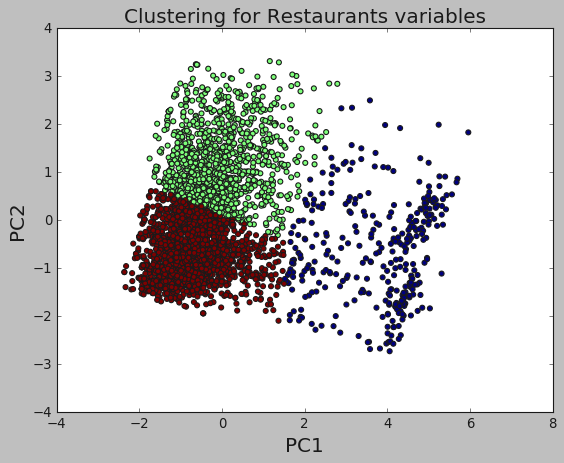

In [74]:
# Choose 3 clusters 
cent, var = initial_restaurants[2]

assignment_res,cdist = cluster.vq.vq(pca_features_restaurants[:,0:2],cent)

plt.style.use('classic')
plt.scatter(pca_features_restaurants[:,0], pca_features_restaurants[:,1], c=assignment_res)
plt.xlabel('PC1',fontsize=18)
plt.ylabel('PC2',fontsize=18)
plt.title('Clustering for Restaurants variables',fontsize=18)
plt.savefig('Figs/cluster_restaurants.png')
plt.show()

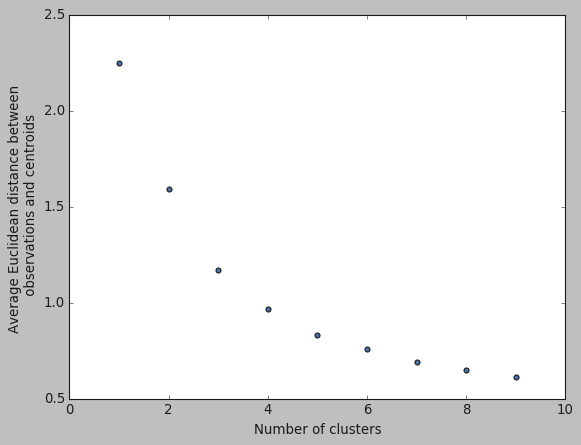

In [75]:
# Elbow plot, for 12 stores variables
initial_stores = [cluster.vq.kmeans(pca_features_stores[:,0:2],i) for i in range(1,10)]
plt.scatter(x=list(range(1,10)),y=[var for (cent,var) in initial_stores])
plt.xlabel('Number of clusters')
plt.ylabel('Average Euclidean distance between \n observations and centroids')

plt.show()

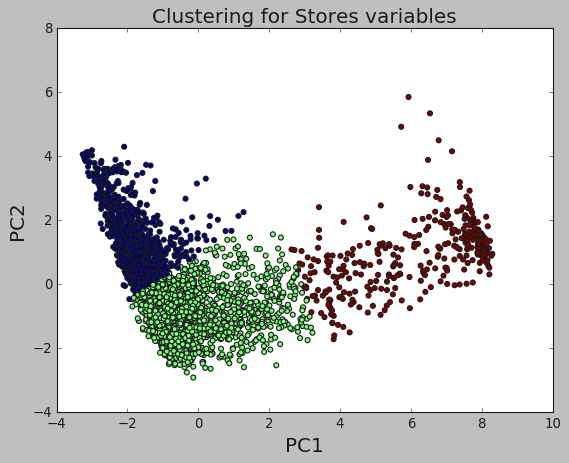

In [76]:
# Choose 3 clusters 
cent, var = initial_stores[2]

assignment_stores,cdist = cluster.vq.vq(pca_features_stores[:,0:2],cent)

plt.style.use('classic')
plt.scatter(pca_features_stores[:,0], pca_features_stores[:,1], c=assignment_stores)
plt.xlabel('PC1',fontsize=18)
plt.ylabel('PC2',fontsize=18)
plt.title('Clustering for Stores variables',fontsize=18)
plt.savefig('Figs/cluster_stores.png')
plt.show()

### Visualize clusters by US counties

In [79]:
import plotly.figure_factory as ff
from colour import Color
start = Color("lightyellow")
colors = list(start.range_to(Color("darkred"),6))

colorscale = [str(color) for color in colors]
colorscale
fips = df_winsorized['FIPS'].tolist()

endpts =[0,1,2]

In [87]:
# fig1 = ff.create_choropleth(
#         fips=fips, values=assignment_shortlist, scope=['usa'],
#         binning_endpoints=endpts,
#         colorscale=colorscale,
#         #show_state_data=True,
#         #show_hover=True,centroid_marker={'opacity':0},
#         #asp=2.9, 
#         title='Clusters based on 15 shortlist features',
# )

# fig1.layout.template = None
# fig1.show()

<img src='Figs/map-15features.png'>

In [86]:
# fig2 = ff.create_choropleth(
#         fips=fips, values=assignment_local, scope=['usa'],
#         binning_endpoints=endpts,
#         colorscale=colorscale,
#         #show_state_data=True,
#         #show_hover=True,centroid_marker={'opacity':0},
#         #asp=2.9, 
#         title='Clusters based on Local features',
# )

# fig2.layout.template = None
# fig2.show()

<img src='Figs/map-local.png'>

In [85]:
# fig3 = ff.create_choropleth(
#         fips=fips, values=assignment_res, scope=['usa'],
#         binning_endpoints=endpts,
#         colorscale=colorscale,
#         #show_state_data=True,
#         #show_hover=True,centroid_marker={'opacity':0},
#         #asp=2.9, 
#         title='Clusters based on Restaurants features',
# )

# fig3.layout.template = None
# fig3.show()

<img src='Figs/map-restaurants.png'>

In [84]:
# fig4 = ff.create_choropleth(
#         fips=fips, values=assignment_stores, scope=['usa'],
#         binning_endpoints=endpts,
#         colorscale=colorscale,
#         #show_state_data=True,
#         #show_hover=True,centroid_marker={'opacity':0},
#         #asp=2.9, 
#         title='Clusters based on Stores features',
# )

# fig4.layout.template = None
# fig4.show()

<img src='Figs/map-stores.png'>